# Tutorial 3: Index Construction Part 2 - Solved

1. Many parallel tasks, such as index construction, are based on the MapReduce architecture.

A. In your own words, describe the overall data flow of the MapReduce architecture. What are the two main phases?

B. Explain the specific input and output for the Map step. What is this task called in the context of index construction?

C. Explain the specific input and output for the Reduce step. What is this task called in the context of index construction?

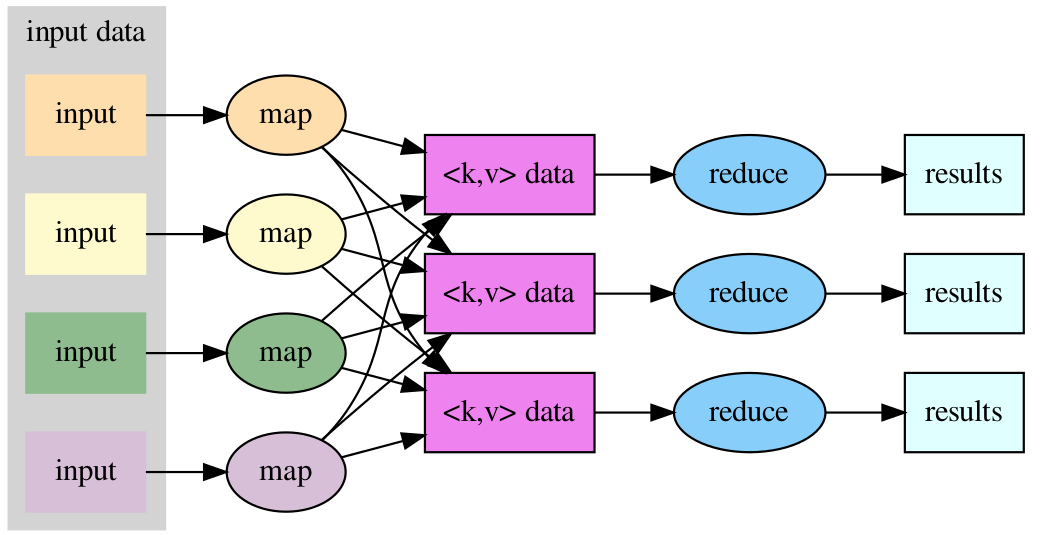

#### Solution: 

A generic MapReduce architecture is a framework for processing large-scale data in parallel across a cluster of machines. It breaks a large computation into two main phases: Map and Reduce (although one should note that the shuffle phase that comes between them is also an important part of the process.)

The general data flow is as follows: Input (can be called splitting) ⇒ Map ⇒ Shuffle ⇒ Reduce ⇒ Output

Splitting: The input data (e.g., a massive text collection) is divided into "splits" or chunks.

Map Phase: Multiple "Parser" (or Mapper) machines process their assigned splits in parallel. Each Parser reads its input and produces a set of intermediate key-value pairs.

Shuffling/Grouping: The framework collects all the values for each unique key from all the Parsers and groups them together.

Reduce Phase: Multiple "Inverter" (or Reducer) machines are assigned a set of keys. Each Inverter takes a key and its list of all associated values and "reduces" this list to a single output.

Final Output: The output of all Inverters forms the final, distributed result (e.g., the term-partitioned index).



The Map Step
Input: The input to a single Map function is a "split" of the raw input data. For index construction, this is a chunk of the document collection.

Output: The output of the Map function is a list of (key, value) pairs. For index construction, the Map task (parsing) generates a (termID, docID) pair for every token it encounters.

The Reduce Step
Input: The input to a single Reduce function is a (key, list of values) pair. The MapReduce framework groups all the values for one key (from all mappers) and sends this list to a single reducer. For example, (termID_Caesar, list(docID_1, docID_2, docID_1)).

Output: The output of the Reduce function is the final, processed result for that key. For index construction, this is the final, sorted postings list for that term, often including term frequencies (e.g., (termID_Caesar, (docID_1: 2, docID_2: 1))).

2. Given the following document collection:

D1: to be or not to be

D2: strive to be the best

a) How can MapReduce be used to count the occurrences of all terms in this document collection? 

b) Perform MapReduce to generate an inverted index

#### Solution: 

a)
map(D1) ⇒ (to, 1), (be, 1), (or, 1), (not, 1), (to, 1), (be, 1)

map(D2) ⇒ (strive, 1), (to, 1), (be, 1), (the, 1), (best, 1)

shuffle ⇒ (to, <1,1,1>), (be, <1,1,1>), (or, <1>), (not, <1>), (strive, <1>), (the, <1>), (best, <1>)

reduce(sum) ⇒ (to, 3), (be, 3), (or, 1), (not, 1), (strive, 1), (the, 1), (best, 1)

b)

map(D1) ⇒ (to, 1), (be, 1), (or, 1), (not, 1), (to, 1), (be, 1)

map(D2) ⇒ (strive, 2), (to, 2), (be, 2), (the, 2), (best, 2)

shuffle ⇒ (to, <1, 1, 2>), (be, <1, 1, 2>), (or, <1>), (not, <1>), (strive, <2>), (the, <2>), (best, <2>)

reduce(to, <1, 1, 2>) $\Rightarrow$ (to, <(1, freq: 2), (2, freq: 1)>)

reduce(be, <1, 1, 2>) $\Rightarrow$ (be, <(1, freq: 2), (2, freq: 1)>)

reduce(or, <1>) $\Rightarrow$ (or, <(1, freq: 1)>)

reduce(not, <1>) $\Rightarrow$ (not, <(1, freq: 1)>)

reduce(strive, <2>) $\Rightarrow$ (strive, <(2, freq: 1)>)

reduce(the, <2>) $\Rightarrow$ (the, <(2, freq: 1)>)

reduce(best, <2>) $\Rightarrow$ (best, <(2, freq: 1)>)

Notation taken from the Chris Manning Textbook. It would be fine to do it like this:

reduce(to, <1, 1, 2>) $\Rightarrow$ (to, <(freq: 3) 1 , 2>)

If one does not care about term count at all and only wants to know whether a term occurs in a document or not, one can do the following for reduce:
reduce(to, <1, 1, 2>) $\Rightarrow$(to, <1, 2>)

3. A Naive Bayes classifier is a simple but powerful algorithm that predicts which category an item belongs to. It's a "classifier" because it classifies data (e.g., "is this email 'spam' or 'not spam'?", "is this article 'sports' or 'politics'?").

To train a Naive Bayes classifier, you first need to count how many times each word appears in each class (the co-occurrence count).

Given the following document collection:

D1 (Class: Sports): "the game was a big win"

D2 (Class: Politics): "the election was a win"

D3 (Class: Sports): "a big loss for the game"

Specify the (key, value) pairs and the Map, Shuffle, and Reduce steps to solve this problem.


#### Solution: 

The key should be the (word, class) pair, so that the reducer can count occurrences for that specific combination.

Solution

This task requires the MapReduce key to be a composite key: the (word, class) tuple. The reducer can then count the occurrences for each specific combination.

1. Map Step

The Map function parses each document, and for every word (token), it emits a key-value pair. The key is (word, class) and the value is 1.

map(D1, 'Sports') → (('the', 'Sports'), 1), (('game', 'Sports'), 1), (('was', 'Sports'), 1), (('a', 'Sports'), 1), (('big', 'Sports'), 1), (('win', 'Sports'), 1)


map(D2, 'Politics') → (('the', 'Politics'), 1), (('election', 'Politics'), 1), (('was', 'Politics'), 1), (('a', 'Politics'), 1), (('win', 'Politics'), 1)

map(D3, 'Sports') → (('a', 'Sports'), 1), (('big', 'Sports'), 1), (('loss', 'Sports'), 1), (('for', 'Sports'), 1), (('the', 'Sports'), 1), (('game', 'Sports'), 1)

2. Shuffle Step

The shuffle step groups all the 1s by their unique (word, class) key.

('the', 'Sports'), <1, 1>

('game', 'Sports'), <1, 1>

('was', 'Sports'), <1>

('a', 'Sports'), <1, 1>

('big', 'Sports'), <1, 1>

('win', 'Sports'), <1>

('the', 'Politics'), <1>

('election', 'Politics'), <1>

('was', 'Politics'), <1>

('a', 'Politics'), <1>

('win', 'Politics'), <1>

('loss', 'Sports'), <1>

('for', 'Sports'), <1>

3. Reduce Step

The Reduce function applies a sum() to the list of values for each key.

reduce(('the', 'Sports'), <1, 1>) → (('the', 'Sports'), 2)

reduce(('game', 'Sports'), <1, 1>) → (('game', 'Sports'), 2)

reduce(('was', 'Sports'), <1>) → (('was', 'Sports'), 1)

reduce(('a', 'Sports'), <1, 1>) → (('a', 'Sports'), 2)

reduce(('big', 'Sports'), <1, 1>) → (('big', 'Sports'), 2)

reduce(('win', 'Sports'), <1>) → (('win', 'Sports'), 1)

reduce(('the', 'Politics'), <1>) → (('the', 'Politics'), 1)

reduce(('election', 'Politics'), <1>) → (('election', 'Politics'), 1)

reduce(('was', 'Politics'), <1>) → (('was', 'Politics'), 1)

reduce(('a', 'Politics'), <1>) → (('a', 'Politics'), 1)

reduce(('win', 'Politics'), <1>) → (('win', 'Politics'), 1)

reduce(('loss', 'Sports'), <1>) → (('loss', 'Sports'), 1)

reduce(('for', 'Sports'), <1>) → (('for', 'Sports'), 1)